# Machine Learning Online Class Exercise 5 | Regularized Linear Regression and Bias-Variance

In [5]:
import numpy as np
import pandas as pd
from scipy.optimize import fmin_cg
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=1.3)

## =========== Part 1: Loading and Visualizing Data =============

In [6]:
#X: Change in water level
#y: Water flowing out of the dam
data = loadmat("ex5data1.mat")
X = data['X']
y = data['y']
Xtest = data['Xtest']
ytest = data['ytest']
Xval = data['Xval']
yval = data['yval']
#print(X.shape,y.shape,Xtest.shape,ytest.shape,Xval.shape,yval.shape)
trcol = np.array([['train'] for i in range(y.shape[0])])
train_d = np.concatenate((X,y,trcol),axis=1)
tecol = np.array([['test'] for i in range(ytest.shape[0])])
test_d = np.concatenate((Xtest,ytest,tecol),axis=1)
vacol = np.array([['val'] for i in range(yval.shape[0])])
val_d = np.concatenate((Xval,yval,vacol),axis=1)
tot_d = np.concatenate((train_d,test_d,val_d),axis=0)
tot_d.shape

(54, 3)

In [7]:
data_df = pd.DataFrame(data=tot_d, index=None, columns=['X','y','type'])
data_df['X'] = data_df['X'].astype(float)
data_df['y'] = data_df['y'].astype(float)
data_df.head()

,X,y,type
0,-15.936758,2.134311,train
1,-29.152979,1.173257,train
2,36.189549,34.359109,train
3,37.492187,36.837955,train
4,-48.058829,2.808965,train


Text(0, 0.5, 'Water flowing out')

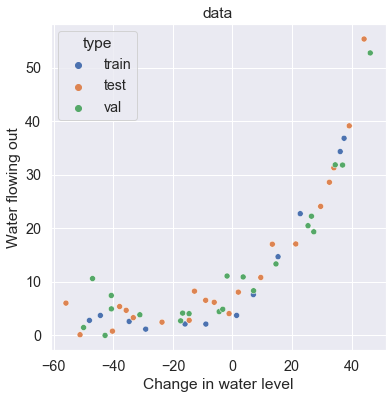

In [8]:
fig0, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(data=data_df, ax=ax, x='X', y='y', hue='type').set(title='data')
ax.set_xlabel("Change in water level")
ax.set_ylabel("Water flowing out")

## =========== Part 2: Regularized Linear Regression Cost =============

In [9]:
# Add bias column to X
X = np.insert(X, 0, np.ones(X.shape[0]), axis=1)
Xtest = np.insert(Xtest, 0, np.ones(Xtest.shape[0]), axis=1)
Xval = np.insert(Xval, 0, np.ones(Xval.shape[0]), axis=1)
X.shape,Xtest.shape,Xval.shape

((12, 2), (21, 2), (21, 2))

The regularized cost function for the regression of the m training examples is
\begin{align}
J(\vec{\theta})=&\frac{1}{2m}\sum_{\alpha=1}^m\left(y_{\alpha}-\sum_{i=1}^n\theta_ix_{i,\alpha}\right)^2+\frac{\lambda}{2m}\sum_{i>0}^n\theta_i^2\\
=&\frac{1}{2m}\sum_{\alpha=1}^m\left(y_{\alpha}- \vec{x}_{\alpha}\cdot\vec{\theta}\right)^2+\frac{\lambda}{2m}\sum_{i>0}^n\theta_i^2.
\end{align}

In [10]:
#Cost funtion J
def J(params, X, y, l):
    theta = params.reshape(X.shape[1],1)
    m = len(y)
    v1 = y-np.matmul(X,theta)
    R = l*(theta[1:]**2).sum()
    return (np.matmul(v1.T,v1)[0][0] + R)/(2*m)

In [11]:
l = 1
theta = np.array([1,1])
Jval = J(theta, X, y, l)
print("Cost at theta = (1,1): {0}".format(Jval))
print("(This value should be about 303.993192)")

Cost at theta = (1,1): 303.9931922202643
(This value should be about 303.993192)


## =========== Part 3: Regularized Linear Regression Gradient =============

The gradient is
\begin{align}
\frac{\partial J}{\partial\theta_k}=&-\frac{1}{m}\sum_{ \alpha=1}^m\left(y_{\alpha}-\vec{x}_{\alpha}\cdot\vec{\theta}\right)x_{k,\alpha}+\frac{\lambda}{m}\theta_k(1-\delta_{k0}).
\end{align}

In [12]:
#Gradient of J
def grad_J(params, X, y, l):
    theta = params.reshape(X.shape[1],1)
    m = len(y)
    v1 = y-np.matmul(X,theta)
    grad = []
    for k in range(X.shape[1]):
        tcol = X[:,k] #k column as 1d array (row vector)
        R = l * (theta[k] if k > 0 else 0)
        grad.append(np.matmul(tcol,v1) + R)
    return -np.asarray(grad).flatten()/m

In [13]:
gr = grad_J(theta, X, y, l)
print(gr.shape)
print("Gradient at theta = (1,1):\n",gr)
print("(this value should be about [-15.303016; 598.250744])")

(2,)
Gradient at theta = (1,1):
 [-15.30301567 598.08407751]
(this value should be about [-15.303016; 598.250744])


## =========== Part 4: Train Linear Regression =============

In [23]:
l = 0
ini_theta = np.zeros((X.shape[1],1))
fin_theta = fmin_cg(J, ini_theta, grad_J, args=(X,y,l))
fin_theta

Optimization terminated successfully.
         Current function value: 22.373906
         Iterations: 2
         Function evaluations: 5
         Gradient evaluations: 5


array([13.08790351,  0.36777923])

In [24]:
def fit_line(theta, N, xmin, xmax):
    line = []
    dx = (xmax-xmin) / N
    for i in np.arange(xmin,xmax+dx,dx):
        line.append([i, theta[0]+i*theta[1]])
    return pd.DataFrame(line, columns=['x', 'y'])

In [25]:
fl = fit_line(fin_theta, 5, -50, 40)

Text(0, 0.5, 'Water flowing out')

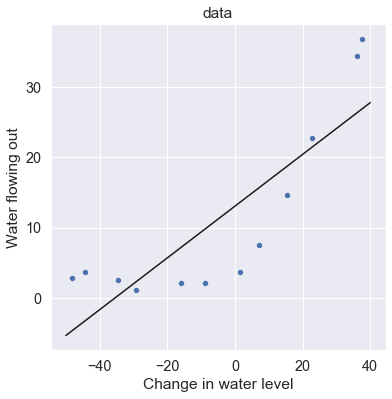

In [26]:
fig1, ax = plt.subplots(figsize=(6, 6))
train_df = data_df[data_df['type']=='train'] 
sns.scatterplot(data=train_df, ax=ax, x='X', y='y').set(title='data')
sns.lineplot(data=fl, ax=ax, x='x', y='y', color='k')
ax.set_xlabel("Change in water level")
ax.set_ylabel("Water flowing out")

This is a model with high bias (underfitting).

## =========== Part 5: Learning Curve for Linear Regression =============